# Predicting Divvy Ridership

## Do some Exploratory Data Analysis, then build a simple Random Forest model and investigate how weather and other features impact ridership
Note that my focus is on model insights, NOT building the best possible model. 

## Tools: 
- Permutation Importance
- Permutation Importance
- SHAP values

## Main conclusions: 
Ridership depends largely on minimum and maximum temperatures more than weather events (though rain/snow have a noticeable effect). Usage also increases across years and differs by weekend/weekday

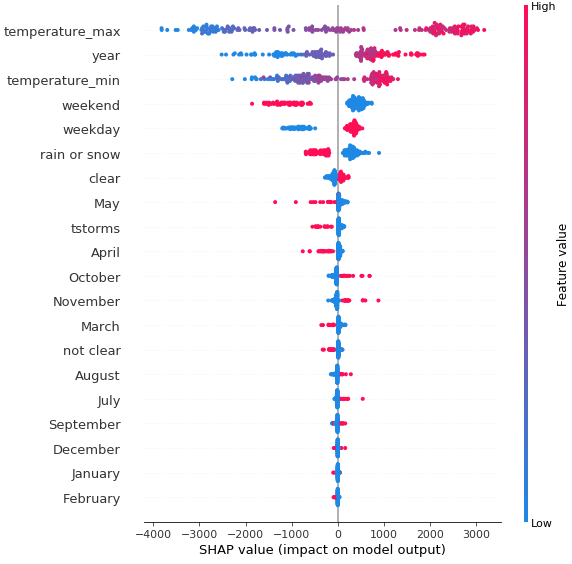

## Notes
- For now, I'm aggregating to day, certainly could try aggregating to hour for more precise impact of weather conditions
- Try add a structured time component rather than just month & year features

In [27]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

import eli5
from eli5.sklearn import PermutationImportance
from pdpbox import pdp, get_dataset, info_plots
import shap

%matplotlib inline

In [2]:
data = pd.read_csv('../data/data.csv')

In [3]:
data.head()

,trip_id,year,month,week,day,hour,usertype,gender,starttime,stoptime,...,from_station_id,from_station_name,latitude_start,longitude_start,dpcapacity_start,to_station_id,to_station_name,latitude_end,longitude_end,dpcapacity_end
0,2355134,2014,6,27,0,23,Subscriber,Male,2014-06-30 23:57:00,2014-07-01 00:07:00,...,131,Lincoln Ave & Belmont Ave,41.939365,-87.668385,15.0,303,Broadway & Cornelia Ave,41.945512,-87.645980,15.0
1,2355133,2014,6,27,0,23,Subscriber,Male,2014-06-30 23:56:00,2014-07-01 00:00:00,...,282,Halsted St & Maxwell St,41.864580,-87.646930,15.0,22,May St & Taylor St,41.869482,-87.655486,15.0
2,2355130,2014,6,27,0,23,Subscriber,Male,2014-06-30 23:33:00,2014-06-30 23:35:00,...,327,Sheffield Ave & Webster Ave,41.921687,-87.653714,19.0,225,Halsted St & Dickens Ave,41.919936,-87.648830,15.0
3,2355129,2014,6,27,0,23,Subscriber,Female,2014-06-30 23:26:00,2014-07-01 00:24:00,...,134,Peoria St & Jackson Blvd,41.877749,-87.649633,19.0,194,State St & Wacker Dr,41.887155,-87.627750,11.0
4,2355128,2014,6,27,0,23,Subscriber,Female,2014-06-30 23:16:00,2014-06-30 23:26:00,...,320,Loomis St & Lexington St,41.872187,-87.661501,15.0,134,Peoria St & Jackson Blvd,41.877749,-87.649633,19.0


In [4]:
data.describe()

,trip_id,year,month,week,day,hour,tripduration,temperature,from_station_id,latitude_start,longitude_start,dpcapacity_start,to_station_id,latitude_end,longitude_end,dpcapacity_end
count,9.495235e+06,9.495235e+06,9.495235e+06,9.495235e+06,9.495235e+06,9.495235e+06,9.495235e+06,9.495235e+06,9.495235e+06,9.495235e+06,9.495235e+06,9.495235e+06,9.495235e+06,9.495235e+06,9.495235e+06,9.495235e+06
mean,9.861173e+06,2.015737e+03,7.161242e+00,2.938068e+01,2.687387e+00,1.362471e+01,1.144686e+01,6.299990e+01,1.799215e+02,4.190017e+01,-8.764473e+01,2.138426e+01,1.807048e+02,4.190069e+01,-8.764496e+01,2.128447e+01
std,4.680018e+06,1.075629e+00,2.708379e+00,1.177941e+01,1.890345e+00,4.858830e+00,7.206061e+00,1.720086e+01,1.217041e+02,3.467450e-02,2.175210e-02,7.644496e+00,1.221144e+02,3.494946e-02,2.181374e-02,7.595932e+00
min,1.109427e+06,2.014000e+03,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,-1.500000e+01,2.000000e+00,4.173665e+01,-8.780287e+01,0.000000e+00,2.000000e+00,4.173665e+01,-8.780287e+01,0.000000e+00
25%,5.941660e+06,2.015000e+03,5.000000e+00,2.100000e+01,1.000000e+00,9.000000e+00,6.033333e+00,5.200000e+01,7.700000e+01,4.188103e+01,-8.765479e+01,1.500000e+01,7.700000e+01,4.188132e+01,-8.765549e+01,1.500000e+01
50%,1.005810e+07,2.016000e+03,7.000000e+00,3.000000e+01,3.000000e+00,1.500000e+01,9.633333e+00,6.690000e+01,1.640000e+02,4.189228e+01,-8.764107e+01,1.900000e+01,1.640000e+02,4.189384e+01,-8.764109e+01,1.900000e+01
75%,1.383260e+07,2.017000e+03,9.000000e+00,3.800000e+01,4.000000e+00,1.700000e+01,1.520000e+01,7.590000e+01,2.680000e+02,4.192008e+01,-8.763058e+01,2.300000e+01,2.730000e+02,4.192169e+01,-8.763058e+01,2.300000e+01
max,1.753670e+07,2.017000e+03,1.200000e+01,5.300000e+01,6.000000e+00,2.300000e+01,6.000000e+01,9.500000e+01,6.260000e+02,4.206431e+01,-8.754939e+01,5.500000e+01,6.260000e+02,4.206431e+01,-8.754939e+01,5.500000e+01


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9495235 entries, 0 to 9495234
Data columns (total 23 columns):
trip_id              int64
year                 int64
month                int64
week                 int64
day                  int64
hour                 int64
usertype             object
gender               object
starttime            object
stoptime             object
tripduration         float64
temperature          float64
events               object
from_station_id      int64
from_station_name    object
latitude_start       float64
longitude_start      float64
dpcapacity_start     float64
to_station_id        int64
to_station_name      object
latitude_end         float64
longitude_end        float64
dpcapacity_end       float64
dtypes: float64(8), int64(8), object(7)
memory usage: 1.6+ GB


## Data documenation as per https://www.kaggle.com/yingwurenjian/chicago-divvy-bicycle-sharing-data/
- trip_idID attached to each trip taken
- yearyear
- monthmonth
- weekweek No.
- day
- hour
- usertype"Customer" is a rider who purchased a 24-Hour Pass; "Subscriber" is a rider who purchased an Annual Membership
- gender
- starttimeday and time trip started, in CST
- stoptimeday and time trip ended, in CST
- tripdurationtime of trip in minutes
- temperature
- events
- from_station_idID of station where trip originated
- from_station_namename of station where trip terminated
- latitude_startstation latitude
- longitude_startstation longitude
- dpcapacity_startnumber of total docks at each station
- to_station_id
- to_station_name
- latitude_end
- longitude_end
- dpcapacity_endnumber of total docks at each station

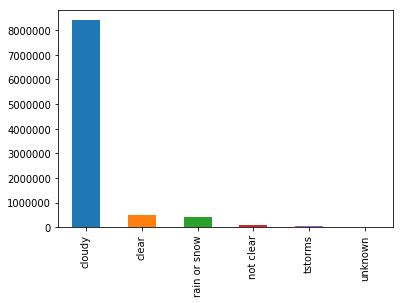

In [6]:
data['events'].value_counts().plot.bar()

# Temporarity
- We can see how Divvy daily patterns differ greatly between weekdays and weekends, including an early commute on Fridays

In [7]:
data['timestamp'] = pd.to_datetime(data.starttime)

data['timestamp_date'] = data.timestamp.dt.date
data['timestamp_month'] = data.timestamp.dt.month
data['timestamp_day'] = data.timestamp.dt.day
data['month_name'] = data.timestamp.dt.month_name()
data['day_name'] = data.timestamp.dt.day_name()

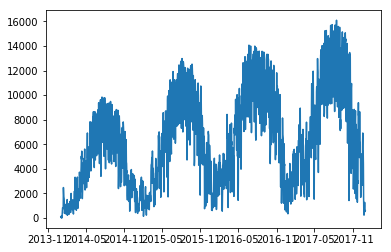

In [8]:
data.timestamp_date.value_counts().plot.line()

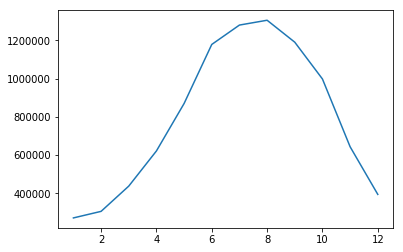

In [9]:
data.timestamp_month.value_counts(sort=False).plot.line()

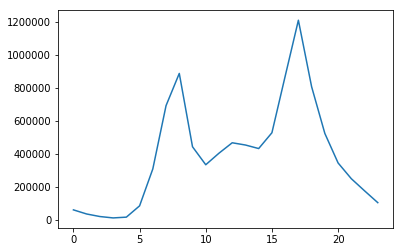

In [10]:
data.hour.value_counts(sort=False).plot.line()

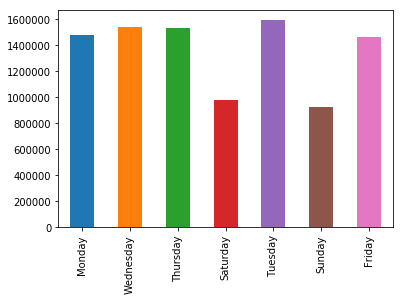

In [11]:
data.day_name.value_counts(sort=False).plot.bar()

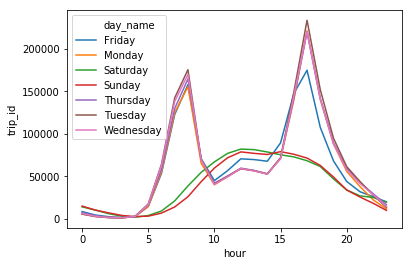

In [12]:
plot_data = data.groupby(['day_name', 'hour'])['trip_id'].count().reset_index()
sns.lineplot(x='hour', y='trip_id', hue='day_name', data=plot_data)

## Aggregate data by day

In [13]:
# Create some binaries
data['weekend'] = np.where((data['day_name'] == 'Saturday') | (data['day_name'] == 'Sunday'), 1, 0)
data['weekday'] = np.where(data['weekend'] == 0, 1, 0)

# Use get_dummies for month and weather
day_dummies =  pd.get_dummies(data['day_name'])
month_dummies =  pd.get_dummies(data['month_name'])
weather_dummies =  pd.get_dummies(data['events'])
gender_dummies =  pd.get_dummies(data['gender'])
dummies = [day_dummies, month_dummies, weather_dummies, gender_dummies]

In [14]:
data = pd.concat([data] + dummies, axis=1)
data.head()

,trip_id,year,month,week,day,hour,usertype,gender,starttime,stoptime,...,October,September,clear,cloudy,not clear,rain or snow,tstorms,unknown,Female,Male
0,2355134,2014,6,27,0,23,Subscriber,Male,2014-06-30 23:57:00,2014-07-01 00:07:00,...,0,0,0,0,0,0,1,0,0,1
1,2355133,2014,6,27,0,23,Subscriber,Male,2014-06-30 23:56:00,2014-07-01 00:00:00,...,0,0,0,0,0,0,1,0,0,1
2,2355130,2014,6,27,0,23,Subscriber,Male,2014-06-30 23:33:00,2014-06-30 23:35:00,...,0,0,0,0,0,0,1,0,0,1
3,2355129,2014,6,27,0,23,Subscriber,Female,2014-06-30 23:26:00,2014-07-01 00:24:00,...,0,0,0,0,0,0,1,0,1,0
4,2355128,2014,6,27,0,23,Subscriber,Female,2014-06-30 23:16:00,2014-06-30 23:26:00,...,0,0,0,0,0,0,1,0,1,0


In [15]:
def aggregate_features(df, varlist, functions, idvars='timestamp_date', add_colname_suffixes=True):
    """
    Function to aggregate variables
    :param df: pd.DataFrame
    :param varlist: str or list of variables to aggregate
    :param functions: str or list of agg functions to apply on varlist
    :param idvars: str or list of groupby vars for aggregation
    :return: aggregated pd.DataFrame indexed by idvars
    """

    if isinstance(varlist, str):
        varlist = [varlist]

    if isinstance(functions, str):
        functions = [functions]

    for i, f in enumerate(functions):
        df2 = df.groupby(idvars)[varlist].agg(f)
        if add_colname_suffixes: 
            varlist2 = [f'{var}_{f}' for var in varlist]
            df2.columns = varlist2
        
        if i == 0: 
            out = df2
        else: 
            out = pd.concat([out, df2], axis=1)
        
    return out

In [16]:
test = aggregate_features(data, 'temperature', ['min', 'max'], 'timestamp_date')

In [17]:
test.head()

,temperature_min,temperature_max
timestamp_date,,
2014-01-01,10.9,21.9
2014-01-02,16.0,21.0
2014-01-03,-8.0,-2.9
2014-01-04,19.9,30.9
2014-01-05,12.9,28.9


In [18]:
data['rides'] = 1

max_vars = ['weekend', 'weekday', 'year'] + list(data.events.unique()) + list(data.month_name.unique())

agg1 = aggregate_features(data, max_vars, ['max'], add_colname_suffixes=False)
agg2 = aggregate_features(data, ['rides', 'Female', 'Male'], 'sum', add_colname_suffixes=False)
agg3 = aggregate_features(data, 'temperature', ['min', 'max'])

data_agg = pd.concat([agg1, agg2, agg3], axis=1).reset_index()

In [19]:
data_agg.head()

,timestamp_date,weekend,weekday,year,tstorms,rain or snow,cloudy,not clear,clear,unknown,...,September,August,December,November,October,rides,Female,Male,temperature_min,temperature_max
0,2014-01-01,0,1,2014,0,1,0,1,0,0,...,0,0,0,0,0,95,16.0,79.0,10.9,21.9
1,2014-01-02,0,1,2014,0,1,0,0,0,0,...,0,0,0,0,0,111,13.0,98.0,16.0,21.0
2,2014-01-03,0,1,2014,0,0,1,0,1,0,...,0,0,0,0,0,6,1.0,5.0,-8.0,-2.9
3,2014-01-04,1,0,2014,0,1,1,0,1,0,...,0,0,0,0,0,181,34.0,147.0,19.9,30.9
4,2014-01-05,1,0,2014,0,1,0,0,0,0,...,0,0,0,0,0,32,5.0,27.0,12.9,28.9


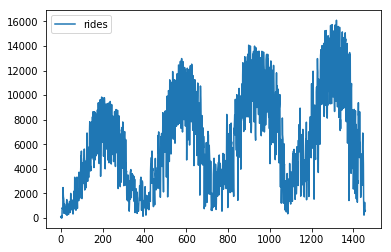

In [20]:
# Sanity check - this should match earlier plot
data_agg[['timestamp_date', 'rides']].plot.line()

## Build Models
First, an OLS with which to compare Randon Forest Results

In [21]:
features = ['weekend', 'weekday', 'year'] + list(data.events.unique()) + list(data.month_name.unique()) + ['temperature_min', 'temperature_max']

In [22]:
y = data_agg.rides
X = data_agg[features]

train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2, random_state=1)

In [23]:
olsmodel = sm.OLS(train_y, train_X)
olsresults = olsmodel.fit()

olsresults.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  rides   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     412.7
Date:                Tue, 25 Sep 2018   Prob (F-statistic):               0.00
Time:                        12:02:46   Log-Likelihood:                -10071.
No. Observations:                1166   AIC:                         2.019e+04
Df Residuals:                    1144   BIC:                         2.030e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
weekend         -1.871e+06   6.44e+04    -29.066      0.000      -2e+06   -1.75e+06
weekday         -1.869e+06   6.44e+04    -29.021      0.000   -1.99e+06   -1.74e+06
year             1083.1942     37.291     29.047      0.000    1010.028    1156.360
tstorms          -940.4074    147.908     -6.358      0.000   -1230.609    -650.206
rain or snow     -816.3509     94.514     -8.637      0.000   -1001.791    -630.911
cloudy           -239.0506    466.967     -0.512      0.609   -1155.258     677.156
not clear        -124.5394    144.127     -0.864      0.388    -407.323     158.244
clear             285.7094     93.433      3.058      0.002     102.391     469.028
unknown           385.9447    981.902      0.393      0.694   -1540.586    2312.475
June            -3.101e+05   1.07e+04    -28.934      0.000   -3.31e+05   -2.89e+05
May             -3.119e+05   1.07e+04    -29.091      0.000   -3.33e+05   -2.91e+05
April           -3.129e+05   1.07e+04    -29.151      0.000   -3.34e+05   -2.92e+05
March           -3.134e+05   1.07e+04    -29.175      0.000   -3.35e+05   -2.92e+05
February        -3.133e+05   1.08e+04    -29.134      0.000   -3.34e+05   -2.92e+05
January         -3.133e+05   1.08e+04    -29.135      0.000   -3.34e+05   -2.92e+05
July            -3.098e+05   1.07e+04    -28.909      0.000   -3.31e+05   -2.89e+05
September         -3.1e+05   1.07e+04    -28.928      0.000   -3.31e+05   -2.89e+05
August          -3.095e+05   1.07e+04    -28.891      0.000   -3.31e+05   -2.89e+05
December        -3.131e+05   1.07e+04    -29.131      0.000   -3.34e+05   -2.92e+05
November         -3.12e+05   1.07e+04    -29.048      0.000   -3.33e+05   -2.91e+05
October         -3.106e+05   1.07e+04    -28.957      0.000   -3.32e+05    -2.9e+05
temperature_min     5.9788      8.152      0.733      0.463     -10.017      21.974
temperature_max    79.4508      7.160     11.097      0.000      65.403      93.499
==============================================================================
Omnibus:                      106.069   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              170.789
Skew:                          -0.650   Prob(JB):                     8.20e-38
Kurtosis:                       4.351   Cond. No.                     1.13e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.71e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

# Let's build a Random Forest Model
My focus here is extracting insights from the model, so I will not do much work in model selection and tuning, just the basics

In [28]:
kfold = KFold(n_splits=5, random_state=42)
rfmodel_untuned = RandomForestRegressor(random_state=42)

In [29]:
%%time
DEPTHS = list(range(3,12))
param_grid = dict(max_depth=DEPTHS)
grid = GridSearchCV(rfmodel_untuned, param_grid=param_grid, cv=kfold, scoring='neg_mean_absolute_error', n_jobs=-1)
grid.fit(train_X, train_y)

# print(grid.cv_results_['mean_test_score'])
print(grid.best_params_)

{'max_depth': 9}
Wall time: 6.23 s


In [30]:
rfmodel = grid.best_estimator_

In [31]:
cv_score = cross_val_score(rfmodel, train_X, train_y, cv=kfold, scoring='neg_mean_absolute_error', n_jobs=-1)
print(cv_score.mean())
print(f'Cross Validation Score = {round(cv_score.mean(), 4)} with std = {round(cv_score.std(), 4)}')

-967.2955963882296
Cross Validation Score = -967.2956 with std = 47.837


Our predictions aren't that great, but that's not our focus right now

In [32]:
print(train_y.mean(), train_y.std())

6529.993996569468 3995.9449534757814


In [33]:
rfmodel.fit(train_X, train_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

## Let's investigate our model, here are some specific tools explained by Kaggle's ML for Insights series
https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values

## Permutation importance
Temperature seems to have by far the strongest impact on number of riders, as well as year (ie, years since Divvy implementation)

In [34]:
perm = PermutationImportance(rfmodel, random_state=1).fit(val_X, val_y)
eli5.show_weights(perm, feature_names = val_X.columns.tolist())

Weight,Feature
0.6208 ± 0.0475,temperature_max
0.2151 ± 0.0264,year
0.2115 ± 0.0478,temperature_min
0.0798 ± 0.0297,weekend
0.0518 ± 0.0064,weekday
0.0213 ± 0.0146,rain or snow
0.0112 ± 0.0117,May
0.0066 ± 0.0025,October
0.0040 ± 0.0028,tstorms
0.0040 ± 0.0017,April


## Partial dependence plots
As expected, ridership increases with temperature, but interestingly the effect occurs between highs of ~40 & ~70 degrees, before and after which temperature changes have little impact on ridership

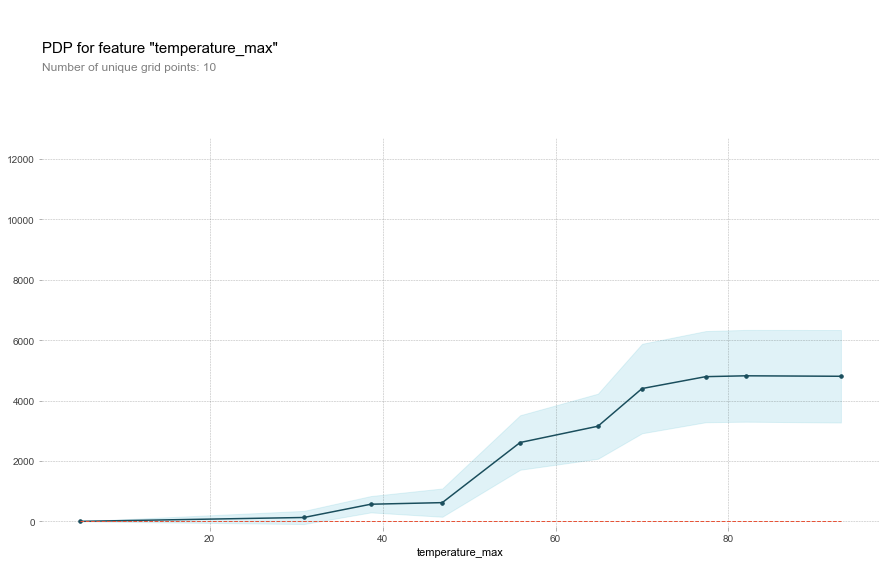

In [35]:
pdp_tempmax = pdp.pdp_isolate(model=rfmodel, dataset=val_X, model_features=val_X.columns.tolist(), feature='temperature_max')
pdp.pdp_plot(pdp_tempmax, 'temperature_max')
plt.show()

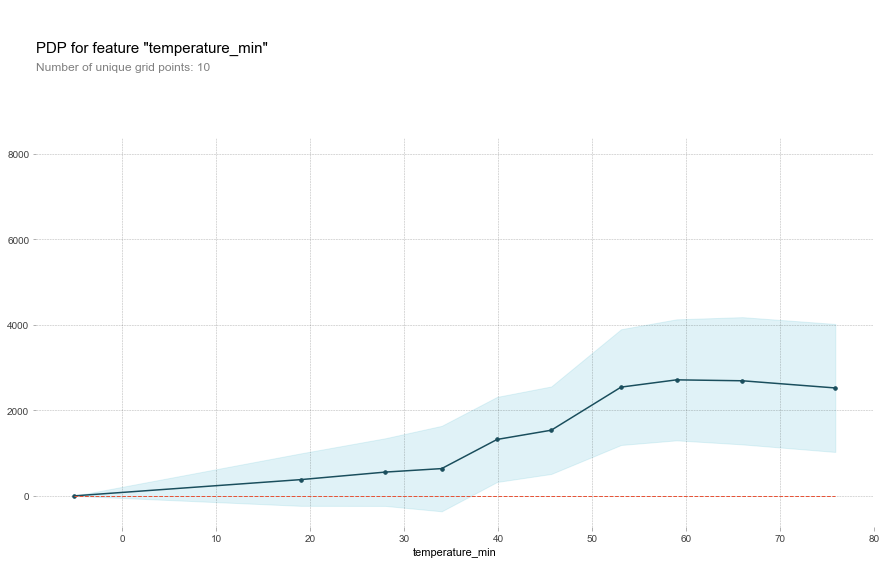

In [36]:
pdp_tempmin = pdp.pdp_isolate(model=rfmodel, dataset=val_X, model_features=val_X.columns.tolist(), feature='temperature_min')
pdp.pdp_plot(pdp_tempmin, 'temperature_min')
plt.show()

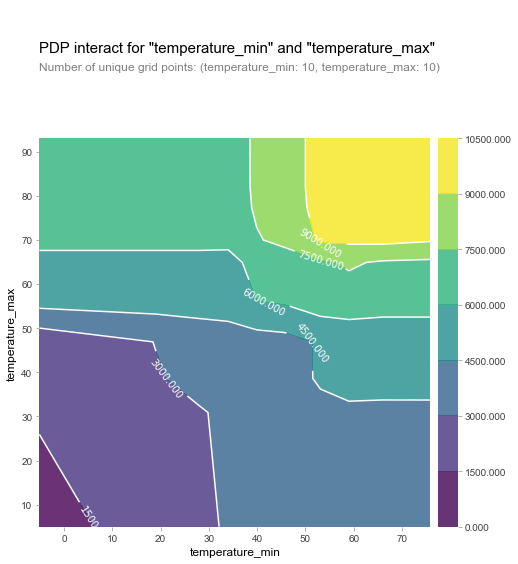

In [37]:
features_to_plot = ['temperature_min', 'temperature_max']
inter1  =  pdp.pdp_interact(model=rfmodel, dataset=val_X, model_features=val_X.columns.tolist(), features=features_to_plot)
pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='contour')
plt.show()

## SHAP values
1) First, we examine the contribution of features to a specific day's prediction

In [38]:
row_to_show = 200
data_for_prediction = val_X.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)
# Create object that can calculate shap values
explainer = shap.TreeExplainer(rfmodel)
# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)

rfmodel.predict(data_for_prediction_array)

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

### Okay, now let's look at SHAP values across features for a subset of our data
There don't seem to be particularly strong interaction effects occuring

In [39]:
val_X_subset = val_X.sample(200, random_state=42)

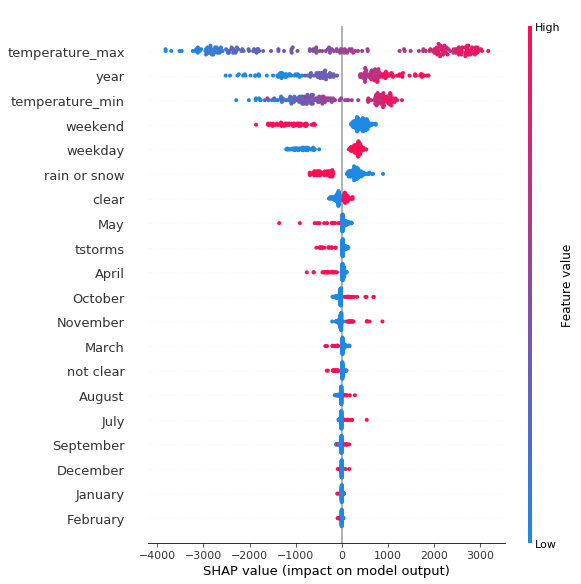

In [40]:
shap_values = explainer.shap_values(val_X_subset)
shap.summary_plot(shap_values, val_X_subset)

### In the following plot, there's no clear interaction between temperature and rain/snow

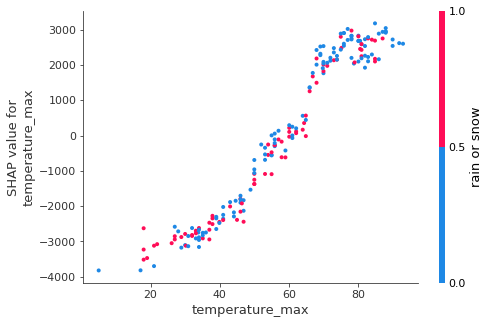

In [42]:
shap.dependence_plot('temperature_max', shap_values, val_X_subset, interaction_index='rain or snow')